In [36]:
from pandas import read_csv
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
import time
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier
from matplotlib import pyplot


In [13]:
#Reading Data
df = read_csv("train.csv", header=0)
#Set Sample for quick calculation
#df = df.sample(frac= 0.1)
#Drop Column id
df = df.drop('id', axis=1)

In [14]:
#Quick EDA with PandasProfileReader
#from ydata_profiling import ProfileReport
#profile = ProfileReport(df, title="Pandas Profiling Report")
#profile.to_widgets()


In [15]:
x_data = df.iloc[:, :-7]
y_data = df.iloc[:, -7:]

In [16]:


y_data['target'] = y_data[['Pastry','Z_Scratch','K_Scatch','Stains','Dirtiness','Bumps','Other_Faults']].idxmax(axis=1)


le = LabelEncoder()
enc = le.fit_transform(y_data.target)
y_data_enc = y_data.assign(target=enc)
target = y_data_enc['target']

Preparing Test Data

In [8]:
#Reading Data
df_test = read_csv("test.csv", header=0)
x_test = df_test.drop('id', axis=1)

# SpotOnCheck

In [ ]:


# prepare models
models = []
#models.append(('ET', ExtraTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('CatB', CatBoostClassifier(verbose=False)))
models.append(('lgbm', LGBMClassifier(verbose=-1)))
models.append(('xgb', XGBClassifier()))
models.append(('GBC',  GradientBoostingClassifier()))
models.append(('ADA',  AdaBoostClassifier()))
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
#models.append(('KNN', KNeighborsClassifier()))
#models.append(('SVM', SVC(probability=True)))
#models.append(('CART', DecisionTreeClassifier()))
#models.append(('NB', GaussianNB()))
#models.append(('QDA', QuadraticDiscriminantAnalysis()))
#models.append(('PA', PassiveAggressiveClassifier()))
#models.append(('DC', DummyClassifier()))
# evaluate each model in turn
results = []
names = []
scoring = 'neg_log_loss'
print(scoring)
for name, model in models:
    start_time = time.time()
    kfold = model_selection.StratifiedKFold(n_splits=10, random_state=None)
    cv_results = model_selection.cross_val_score(model, x_data, target, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    mean_scoring = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    stop_time = time.time()
    duration = stop_time - start_time
    print(mean_scoring)
    print(f"Iteration {name}: {duration:.6f} seconds")

# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()


SpotOnCheck Findings  
Seems like Catboost, lgbm, xgboost and gbc perform well. Next Step should be Hyperparameter Tuning and possible ensemble Model.

SpotonCheck Stacking Ensemble, Soft Voting

>CatB -1.001 (0.015)
>lgbm -1.015 (0.016)
>xgb -1.053 (0.017)
>GBC -0.997 (0.015)
>stacking -1.024 (0.015)
>soft_voting -0.986 (0.014)


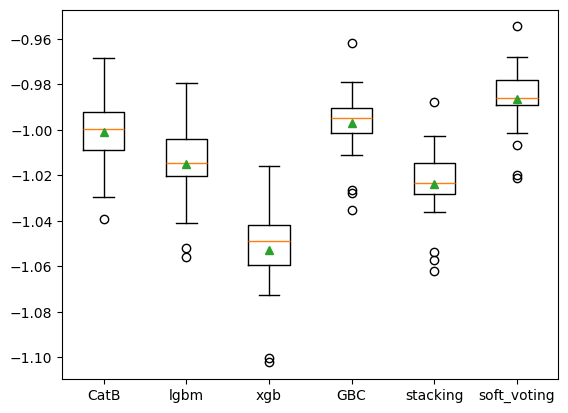

In [70]:

# compare ensemble to each baseline classifier
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier
from matplotlib import pyplot
# get a stacking ensemble of models
def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('CatB', CatBoostClassifier(verbose=False)))
    level0.append(('lgbm', LGBMClassifier(verbose=-1)))
    level0.append(('xgb', XGBClassifier()))
    level0.append(('GBC', GradientBoostingClassifier()))
    # define meta learner model
    level1 = LogisticRegression()
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model

def get_voting_soft():
    # define the base models
    models = list()
    models.append(('CatB', CatBoostClassifier(verbose=False)))
    models.append(('lgbm', LGBMClassifier(verbose=-1)))
    models.append(('xgb', XGBClassifier()))
    models.append(('GBC',  GradientBoostingClassifier()))
    # define the voting ensemble
    ensemble = VotingClassifier(estimators=models, voting='soft')
    return ensemble
# get a list of models to evaluate
def get_models():
    models = dict()
    models['CatB'] = CatBoostClassifier(verbose=False)
    models['lgbm'] = LGBMClassifier(verbose=-1)
    models['xgb'] = XGBClassifier()
    models['GBC'] = GradientBoostingClassifier()
    models['stacking'] = get_stacking()
    models['soft_voting'] = get_voting_soft()
    return models
# evaluate a give model using cross-validation

def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='neg_log_loss', cv=cv, n_jobs=-1, error_score='raise')
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, x_data, target)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()


Ensemble Results  
Stacking slightly worse, soft voting slightly better
>CatB -1.001 (0.015)  
>lgbm -1.015 (0.016)  
>xgb -1.053 (0.017)  
>GBC -0.997 (0.015)  
>stacking -1.024 (0.015)  
>soft_voting -0.986 (0.014)

# Hyperparameter Tuning

## Catboost Hyperparameter Tuning

### Fit and Predict

In [29]:
model = CatBoostClassifier(verbose=False)
model.fit(x_data, target)
pred = model.predict_proba(x_test)
submission = pd.DataFrame(pred,columns=le.classes_)
submission['id'] = df_test['id']
submission.to_csv("CBoostNoTune.csv",index=False)

## XGBoost Hyperparameter Tuning  

In [26]:
import numpy as np
import pandas as pd
from pandas import read_csv
from sklearn.model_selection import*
import optuna
import xgboost as xgb
from sklearn.metrics import log_loss

In [34]:
def objective(trial):
    #Define Hyperparameter Search Space
    params_optuna = {
        "objective" : "multi:softprob",
        "num_class" : 7,
        "tree_method" : "gpu_hist",
        "n_estimators" : trial.suggest_int("n_estimators", 50, 1000),
        "max_depth" : trial.suggest_int("max_depth", 3, 19),
        "max_leaves" : trial.suggest_int("max_leaves", 15, 149),
        "grow_policy" : trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        "learning_rate" : trial.suggest_float("learning_rate", 0, 1),
        "booster" : trial.suggest_categorical("booster", ["gbtree"]),
        "reg_alpha" : trial.suggest_float("reg_alpha", 0, 1),
        "reg_lambda" : trial.suggest_float("reg_lambda", 0, 1),
        "gamma" : trial.suggest_float("gamma", 0, 10),
        "min_child_weight" : trial.suggest_float("min_child_weight", 0, 20),
        "subsample" : trial.suggest_float("subsample", 0.5, 0.9)
    }
    
    #KFold
    skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    scores = []
    for train_index,test_index in skf.split(x_data,target):
        X_train, y_train = x_data.iloc[train_index],target.iloc[train_index]
        X_val, y_val = x_data.iloc[test_index],target.iloc[test_index]
    
        classifier = xgb.XGBClassifier(**params_optuna)
        classifier.fit(X_train, y_train)
    
        y_pred = classifier.predict_proba(X_val)
        score = log_loss(y_val, y_pred)
        scores.append(score)
    
    return np.mean(scores)
study = optuna.create_study(study_name="XGB_KFold", direction="minimize")
study.optimize(objective, n_trials=100)
study_df = study.trials_dataframe()
print(study.best_value)
print(study.best_params)

[I 2024-03-06 11:37:31,171] A new study created in memory with name: XGB_KFold
[I 2024-03-06 11:37:42,646] Trial 0 finished with value: 0.9957581160226308 and parameters: {'n_estimators': 97, 'max_depth': 10, 'max_leaves': 73, 'grow_policy': 'lossguide', 'learning_rate': 0.22972300664630607, 'booster': 'gbtree', 'reg_alpha': 0.8303098158793843, 'reg_lambda': 0.01785917971815909, 'gamma': 2.2658971546559803, 'min_child_weight': 2.9214295935430346, 'subsample': 0.8666572898006645}. Best is trial 0 with value: 0.9957581160226308.
[I 2024-03-06 11:38:38,880] Trial 1 finished with value: 1.2785894613407305 and parameters: {'n_estimators': 246, 'max_depth': 17, 'max_leaves': 29, 'grow_policy': 'lossguide', 'learning_rate': 0.3994472687314816, 'booster': 'gbtree', 'reg_alpha': 0.270315303574742, 'reg_lambda': 0.5025976522765363, 'gamma': 0.27706510132778916, 'min_child_weight': 12.518013014917262, 'subsample': 0.5259985206726928}. Best is trial 0 with value: 0.9957581160226308.
[I 2024-03-06 

0.9822704070357048
{'n_estimators': 590, 'max_depth': 11, 'max_leaves': 16, 'grow_policy': 'depthwise', 'learning_rate': 0.0552223218868165, 'booster': 'gbtree', 'reg_alpha': 0.6472657948113174, 'reg_lambda': 0.13254703840445914, 'gamma': 3.1149929790252133, 'min_child_weight': 1.794124484207816, 'subsample': 0.8018823156535407}


In [37]:
print(study.best_params)

{'n_estimators': 590, 'max_depth': 11, 'max_leaves': 16, 'grow_policy': 'depthwise', 'learning_rate': 0.0552223218868165, 'booster': 'gbtree', 'reg_alpha': 0.6472657948113174, 'reg_lambda': 0.13254703840445914, 'gamma': 3.1149929790252133, 'min_child_weight': 1.794124484207816, 'subsample': 0.8018823156535407}


Optuna XBG best score  
0.9822704070357048

Optuna XGB best params  
{'n_estimators': 590, 'max_depth': 11, 'max_leaves': 16, 'grow_policy': 'depthwise', 'learning_rate': 0.0552223218868165, 'booster': 'gbtree', 'reg_alpha': 0.6472657948113174, 'reg_lambda': 0.13254703840445914, 'gamma': 3.1149929790252133, 'min_child_weight': 1.794124484207816, 'subsample': 0.8018823156535407}

### Fit and Predict

In [30]:
params_xgb = {'n_estimators': 590, 'max_depth': 11, 'max_leaves': 16, 'grow_policy': 'depthwise', 'learning_rate': 0.0552223218868165, 'booster': 'gbtree', 'reg_alpha': 0.6472657948113174, 'reg_lambda': 0.13254703840445914, 'gamma': 3.1149929790252133, 'min_child_weight': 1.794124484207816, 'subsample': 0.8018823156535407}
model = XGBClassifier(**params_xgb)
model.fit(x_data, target)
pred = model.predict_proba(x_test)
submission = pd.DataFrame(pred,columns=le.classes_)
submission['id'] = df_test['id']
submission.to_csv("XGBTuned.csv",index=False)

## GBC Hyperparameter Tuning

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
def objective(trial):
    #Define Hyperparameter Search Space
    params_optuna = {
        "learning_rate" : trial.suggest_float("learning_rate", 0, 1),
 #       "n_estimators" : trial.suggest_int("n_estimators", 50, 1000),
  #      "subsample" : trial.suggest_float("subsample", 0, 1),
   #     "criterion" :  trial.suggest_categorical("criterion", ["friedman_mse", "squared_error"]),
    #    "min_samples_split" : trial.suggest_float("min_samples_split", 0, 1),
     #   "min_samples_leaf" : trial.suggest_float("min_samples_leaf", 0, 1),
      #  "max_depth" : trial.suggest_int("max_depth", 3, 50),
       # "min_impurity_decrease" : trial.suggest_float("min_impurity_decrease", 0, 1)
    }
    
    #KFold
    skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    scores = []
    for train_index,test_index in skf.split(x_data,target):
        X_train, y_train = x_data.iloc[train_index],target.iloc[train_index]
        X_val, y_val = x_data.iloc[test_index],target.iloc[test_index]
    
        classifier = GradientBoostingClassifier(**params_optuna)
        classifier.fit(X_train, y_train.values.ravel())
    
        y_pred = classifier.predict_proba(X_val)
        X_train_pred = classifier.predict_proba(X_train)[:,1]
        
        score = log_loss(y_val, y_pred.astype(np.float64))
        scores.append(score)
    return np.mean(scores)
study = optuna.create_study(study_name="GBC_SKFold", direction="minimize")
study.optimize(objective, n_trials=10)
study_df = study.trials_dataframe()
print(study.best_value)
print(study.best_params)

In [45]:
print(study.best_value)
print(study.best_params)

1.6386714547844086
{'learning_rate': 0.5521561841852183, 'n_estimators': 195, 'subsample': 0.9459418531220104, 'criterion': 'squared_error', 'min_samples_split': 0.9422046708085787, 'min_samples_leaf': 0.18938317561489681, 'max_depth': 43, 'min_impurity_decrease': 0.7032570513302495}


## LGB Hyperparameter Tuning

In [40]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss

In [41]:
x_data_lgb = x_data.to_numpy()
target_lgb = target.to_numpy()

def objective(trial):
    params = {
        'device' : 'gpu',
        'objective': 'softmax',
        'metric': 'log_loss',
        'num_class': 7,
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 12),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
    # Perform k-fold cross-validation
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    for train_idx, valid_idx in kf.split(x_data_lgb, target_lgb):
        dtrain = lgb.Dataset(x_data_lgb[train_idx], label=target_lgb[train_idx])
        dvalid = lgb.Dataset(x_data_lgb[valid_idx], label=target_lgb[valid_idx])
        model = lgb.train(params, dtrain, valid_sets=[dvalid], num_boost_round=50)
        valid_pred = model.predict(x_data_lgb[valid_idx])
        score = log_loss(target_lgb[valid_idx], valid_pred)
        scores.append(score)
    return np.mean(scores)
study = optuna.create_study(direction='minimize')
# Suppress INFO logs by setting the logging level to WARNING
#optuna.logging.set_verbosity(optuna.logging.ERROR)
study.optimize(objective, n_trials=2)
# Access the best hyperparameters and corresponding log loss
best_params = study.best_params
best_log_loss = study.best_value
study_df = study.trials_dataframe()
print(best_params)
print(best_log_loss)

[I 2024-03-08 14:07:40,603] A new study created in memory with name: no-name-d11b18dc-ff8f-471c-9c98-19ec58a80c4d
[W 2024-03-08 14:07:40,622] Trial 0 failed with parameters: {'lambda_l1': 1.6569225149069977, 'lambda_l2': 2.9064777110712443, 'num_leaves': 6, 'feature_fraction': 0.46577424662596323, 'bagging_fraction': 0.7015902710118831, 'bagging_freq': 2, 'min_child_samples': 6} because of the following error: LightGBMError("Multiclass objective and metrics don't match").
Traceback (most recent call last):
  File "c:\Users\LArns\Desktop\meica\.conda\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\LArns\AppData\Local\Temp\ipykernel_14304\2443411315.py", line 24, in objective
    model = lgb.train(params, dtrain, valid_sets=[dvalid], num_boost_round=50)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\LArns\Desktop\meica\.conda\Lib\site

LightGBMError: Multiclass objective and metrics don't match

In [18]:
print(best_params)
print(best_log_loss)

{'lambda_l1': 0.2162230242845769, 'lambda_l2': 1.4229898006635455, 'num_leaves': 12, 'feature_fraction': 0.6710671976929891, 'bagging_fraction': 0.8615122322908715, 'bagging_freq': 1, 'min_child_samples': 92}
0.9811067013486952


Optuna LGB best params  
0.9811067013486952  
{'lambda_l1': 0.2162230242845769, 'lambda_l2': 1.4229898006635455, 'num_leaves': 12, 'feature_fraction': 0.6710671976929891, 'bagging_fraction': 0.8615122322908715, 'bagging_freq': 1, 'min_child_samples': 92}  


### Fit and Predict

In [33]:
params_lgb = {'lambda_l1': 0.2162230242845769, 'lambda_l2': 1.4229898006635455, 'num_leaves': 12, 'feature_fraction': 0.6710671976929891, 'bagging_fraction': 0.8615122322908715, 'bagging_freq': 1, 'min_child_samples': 92}  
model = LGBMClassifier(**params_lgb, verbose=-1)
model.fit(x_data, target)
pred = model.predict_proba(x_test)
submission = pd.DataFrame(pred,columns=le.classes_)
submission['id'] = df_test['id']
submission.to_csv("LGBTuned.csv",index=False)

# SpotOnCheck Stacking Ensemble, Soft Voting with tuned Hyperparameters

In [34]:
xgb_params= {'n_estimators': 590, 'max_depth': 11, 'max_leaves': 16, 'grow_policy': 'depthwise', 'learning_rate': 0.0552223218868165, 'booster': 'gbtree', 'reg_alpha': 0.6472657948113174, 'reg_lambda': 0.13254703840445914, 'gamma': 3.1149929790252133, 'min_child_weight': 1.794124484207816, 'subsample': 0.8018823156535407}
lgb_params = {'lambda_l1': 0.2162230242845769, 'lambda_l2': 1.4229898006635455, 'num_leaves': 12, 'feature_fraction': 0.6710671976929891, 'bagging_fraction': 0.8615122322908715, 'bagging_freq': 1, 'min_child_samples': 92} 

>CatB -1.001 (0.015)
>lgbm -0.980 (0.014)
>xgb -0.980 (0.014)
>stacking -1.017 (0.015)
>soft_voting -0.976 (0.013)


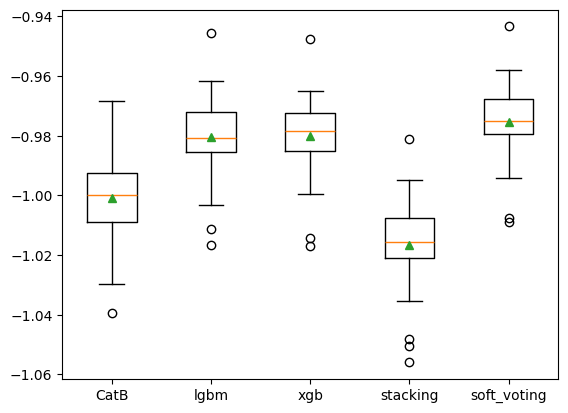

In [9]:

# get a stacking ensemble of models
def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('CatB', CatBoostClassifier(verbose=False)))
    level0.append(('lgbm', LGBMClassifier(**lgb_params, verbose=-1)))
    level0.append(('xgb', XGBClassifier(**xgb_params)))
    #level0.append(('GBC', GradientBoostingClassifier(**gbc_params)))
    # define meta learner model
    level1 = LogisticRegression()
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model

def get_voting_soft():
    # define the base models
    models = list()
    models.append(('CatB', CatBoostClassifier(verbose=False)))
    models.append(('lgbm', LGBMClassifier(**lgb_params, verbose=-1)))
    models.append(('xgb', XGBClassifier(**xgb_params)))
   # models.append(('GBC',  GradientBoostingClassifier(**gbc_params)))
    # define the voting ensemble
    ensemble = VotingClassifier(estimators=models, voting='soft')
    return ensemble
# get a list of models to evaluate
def get_models():
    models = dict()
    models['CatB'] = CatBoostClassifier(verbose=False)
    models['lgbm'] = LGBMClassifier(**lgb_params, verbose=-1)
    models['xgb'] = XGBClassifier(**xgb_params)
   # models['GBC'] = GradientBoostingClassifier(**gbc_params)
    models['stacking'] = get_stacking()
    models['soft_voting'] = get_voting_soft()
    return models
# evaluate a give model using cross-validation

def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='neg_log_loss', cv=cv, n_jobs=-1, error_score='raise')
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, x_data, target)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()


Results SpotonCheck Tuned  
>CatB -1.001 (0.015)  
>lgbm -0.980 (0.014)  
>xgb -0.980 (0.014)  
>stacking -1.017 (0.015)  
>soft_voting -0.976 (0.013)  

### Fit and Predict Vote Classifier

In [39]:
def get_voting_soft():
    # define the base models
    models = list()
    models.append(('CatB', CatBoostClassifier(verbose=False)))
    models.append(('lgbm', LGBMClassifier(**lgb_params, verbose=-1)))
    models.append(('xgb', XGBClassifier(**xgb_params)))
    models.append(('GBC',  GradientBoostingClassifier()))
    # define the voting ensemble
    ensemble = VotingClassifier(estimators=models, voting='soft')
    return ensemble

model = get_voting_soft()
model.fit(x_data, target)
pred = model.predict_proba(x_test)
submission = pd.DataFrame(pred,columns=le.classes_)
submission['id'] = df_test['id']
submission.to_csv("VotingSoftTunedtest.csv",index=False)

# para1